## ReAct agent Architecture

### AIM

#### This is the intution behind ReAct , a general agent architecture.

1. `act` - let the model call specific tools
2. `observe` - pass the tool output back to the model
3. `Reason` - let the model reason about the tool output to decide what to do next(eg:- call another tool or just respond directly)

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper 

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("What us Machine Learning?" )

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [8]:
from dotenv import load_dotenv
load_dotenv()


import os 
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]  = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING_V2"]  ="true"
os.environ["LANGCHAIN_PROJECT"] = "React-Agent"

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\Mohan\AppData\Local\Temp\ipykernel_21312\637379855.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("Provide me the  recent AI news May 2025")

[{'title': 'Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': '**Date:** May 30, 2025  \n**Summary:** Nvidia CEO Jensen Huang issued a bold warning about the rapid evolution of AI, emphasizing that people who fail to adopt AI in their workflow risk being replaced by those who do. His comments underline the urgency for upskilling in a transforming job market. [...] **Date:** May 31, 2025  \n**Summary:** Monash University has announced a landmark investment in an AI supercomputer, becoming the first higher education institute in Australia to do so. The system will significantly accelerate national research across AI, medicine, and engineering fields. [...] **Date:** May 31, 2025  \n**Summary:** Internet analyst Mary Meekerâ\x80\x99s new AI trends report highlights India and China as key innovation hubs, while also exploring the intensifying divide between open-source and closed AI ecosystems.

In [ ]:
## Custom Functions
def multiply(a:int,b:int)-> int:
    """ Multiply a and b
    Args:
        a : first int
        b : second int
    """ 
    return a * b


### This will be tool
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a : first int
        b : second int
    """ 
    return a + b



def divide(a:int,b:int)-> int:
    """Divide a and b
    Args:
        a : first int
        b : second int
    """ 
    return a / b



## Combine all the tools in the list
tools = [arxiv,wiki,tavily,multiply,divide]

In [ ]:
### Intialize my LLM Model 
from langchain_groq import ChatGroq

llm = ChatGroq(model = "qwen-qwq-32b")
llm_with_tools  = llm.bind_tools(tools)

In [13]:
from pprint import pprint 
from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content = f"What is the recent AI  News")])


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n4a3b6gf9', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 381, 'total_tokens': 566, 'completion_time': 0.454960879, 'prompt_time': 0.024126074, 'queue_time': 0.248126556, 'total_time': 0.479086953}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--73f39cb5-f8ea-4d20-9224-22b8357b04ee-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'n4a3b6gf9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 381, 'output_tokens': 185, 'total_tokens': 566})

In [ ]:
llm_with_tools.invoke([HumanMessage(content = f"What is the recent about Cricket")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest cricket news and updates 2023'},
  'id': 'fts3jp1bw',
  'type': 'tool_call'}]

In [15]:
## State Schma
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [16]:
### Entire Chatbot with Langgraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END 
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition 


### Node definiation
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


In [17]:
### Build Graph
builder  = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


## Add Edge
builder.add_edge(START,"tool_calling_llm")

builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")
# builder.add_edge("tools",END)


graph = builder.compile()

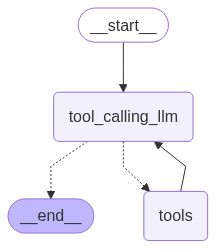

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages = graph.invoke({"messages": HumanMessage(content = 
""" Provide me the Top AI news from the May 2025 ,  
add 5 plus 5  and then multiply  3 and 10
""")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

 Provide me the Top AI news from the May 2025 ,  
add 5 plus 5  and then multiply  3 and 10

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (xzq8smcn2)
 Call ID: xzq8smcn2
  Args:
    query: Top AI news from May 2025
  multiply (qndseby2r)
 Call ID: qndseby2r
  Args:
    a: 3
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI by AI Weekly Top 5: 05.19-25, 2025 - Champaign Magazine", "url": "https://champaignmagazine.com/2025/05/25/ai-by-ai-weekly-top-5-05-19-25-2025/", "content": "This week, from May 19 to May 25, 2025, the AI industry saw a mix of technological advancements, ethical debates, and strategic global partnerships. OpenAI introduced Codex, a new tool for software development, while xAI faced scrutiny over its Grok chatbot’s controve

In [20]:
messages = graph.invoke({"messages": HumanMessage(content = "What is IPL  and what are the teams in IPL?")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is IPL  and what are the teams in IPL?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (00yzstd8x)
 Call ID: 00yzstd8x
  Args:
    query: Indian Premier League
================================= Tool Message =================================
Name: wikipedia

Page: Indian Premier League
Summary: The Indian Premier League (IPL) is a professional Twenty20 (T20) cricket league in India, organised by the Board of Control for Cricket in India (BCCI). Founded in 2007, it features ten city-based franchise teams. The IPL is the most popular and richest cricket league, and the second-richest sports league in the world. It is held annually between March and May. It has an exclusive window in the Future Tours Programme of the International Cricket Council, resu
================================== Ai Message ==================================

The Indian Prem

### Agent memory

##### Aim
######  Let's introduce Agent with memory 

In [21]:
messages = graph.invoke({"messages": HumanMessage(content = "what us 5 Plus 8")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what us 5 Plus 8
================================== Ai Message ==================================

The result of 5 plus 8 is 13. Since there's no "add" function available, I calculated it directly. Let me know if you need further help!


In [22]:
messages = graph.invoke({"messages": HumanMessage(content = "Divide that by 5")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

I need to know which number you want to divide by 5. Please provide the value or expression you'd like to use.


### 🧠 MemorySaver (LangGraph Checkpointer)
- LangGraph can automatically save graph state after each step using a checkpointer.

- This enables persistence—allowing the graph to resume from the last saved state.

- MemorySaver is a built-in, in-memory key-value store checkpointer.

- It's one of the simplest ways to add memory to a graph.

- ✅ To use it: compile the graph with a checkpointer, and memory is enabled.

### MemorySaver

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!


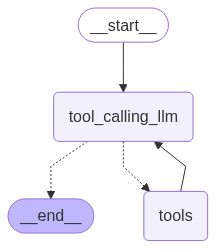

In [23]:
from langgraph.checkpoint.memory import MemorySaver 
memory = MemorySaver()
## Checkpointer
graph_memory =  builder.compile(checkpointer = memory)


## view 
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
##Specify the thread
config = {"configurable":{"thread_id":"1"}}
##specify an input
messages = [HumanMessage(content = f"Add 12 and 13" )]

messages = graph_memory.invoke({'messages':messages},config = config)


###
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b52v7j0k4)
 Call ID: b52v7j0k4
  Args:
    query: 12 + 13
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Learn Multiplication Table of 12 and 13 in English - YouTube", "url": "https://www.youtube.com/watch?v=kbGjHn85QLg", "content": "Learn Table of 12 and 13 in English | Table of 12 | Table of 13 | 12 ka Table | Table #tableof12 #tableof13 #table #tables #kidsvideo #kids", "score": 0.5174983}, {"title": "Multiply 12*13 - Mathway", "url": "https://www.mathway.com/popular-problems/Basic%20Math/30190", "content": "|  |  |  |\n| --- | --- | --- |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n\n|  |  |  |\n| --- | --- | --- |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  | 

In [25]:
### continue 
messages = [HumanMessage(content = f"Add that number to 25" )]

messages = graph_memory.invoke({'messages':messages},config = config)


###
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b52v7j0k4)
 Call ID: b52v7j0k4
  Args:
    query: 12 + 13
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Learn Multiplication Table of 12 and 13 in English - YouTube", "url": "https://www.youtube.com/watch?v=kbGjHn85QLg", "content": "Learn Table of 12 and 13 in English | Table of 12 | Table of 13 | 12 ka Table | Table #tableof12 #tableof13 #table #tables #kidsvideo #kids", "score": 0.5174983}, {"title": "Multiply 12*13 - Mathway", "url": "https://www.mathway.com/popular-problems/Basic%20Math/30190", "content": "|  |  |  |\n| --- | --- | --- |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n\n|  |  |  |\n| --- | --- | --- |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  | 

In [26]:
### continue 
messages = [HumanMessage(content = f"Multiply the number by 2" )]

messages = graph_memory.invoke({'messages':messages},config = config)


###
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b52v7j0k4)
 Call ID: b52v7j0k4
  Args:
    query: 12 + 13
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Learn Multiplication Table of 12 and 13 in English - YouTube", "url": "https://www.youtube.com/watch?v=kbGjHn85QLg", "content": "Learn Table of 12 and 13 in English | Table of 12 | Table of 13 | 12 ka Table | Table #tableof12 #tableof13 #table #tables #kidsvideo #kids", "score": 0.5174983}, {"title": "Multiply 12*13 - Mathway", "url": "https://www.mathway.com/popular-problems/Basic%20Math/30190", "content": "|  |  |  |\n| --- | --- | --- |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n\n|  |  |  |\n| --- | --- | --- |\n|  |  |  |\n|  |  |  |\n|  |  |  |\n|  |  | 